In [30]:
import matplotlib
import numpy as np
import torch
import torch.nn as nn
from utils.data import *
from models.Forecaster import LSTMForecaster, LSTM_FC

In [31]:
data = get_data("data/data.csv", 'cuda', False)[0][:, :1]

Reading data from file data/data.csv
========== Data Loaded ==========
                btc   gold_inter
count   1826.000000  1826.000000
mean   12206.068281  1463.644496
std    14043.891627   249.329936
min      594.080000  1125.700000
25%     3994.982500  1266.050000
50%     7924.460000  1327.825000
75%    11084.730000  1724.150000
max    63554.440000  2067.150000
Totally 1826 days of trade, with 571 unavailable for gold.
========== Data Loaded ==========


In [32]:
# train_idx = torch.randint(0, data.shape[0] - train_len, [1])[0]
# test_idx = torch.randint(0, data.shape[0] - test_len, [1])[0]

bs_len = 50
fc_len = 16
batch_size = 8

train_seq = data[:1200+fc_len]
valid_seq  = data[1200:1500+fc_len]
test_seq  = data[1500:]

In [33]:
forecaster = LSTM_FC(1, fc_len, 1)
optimizer = torch.optim.SGD(forecaster.parameters(), lr=1e-3)

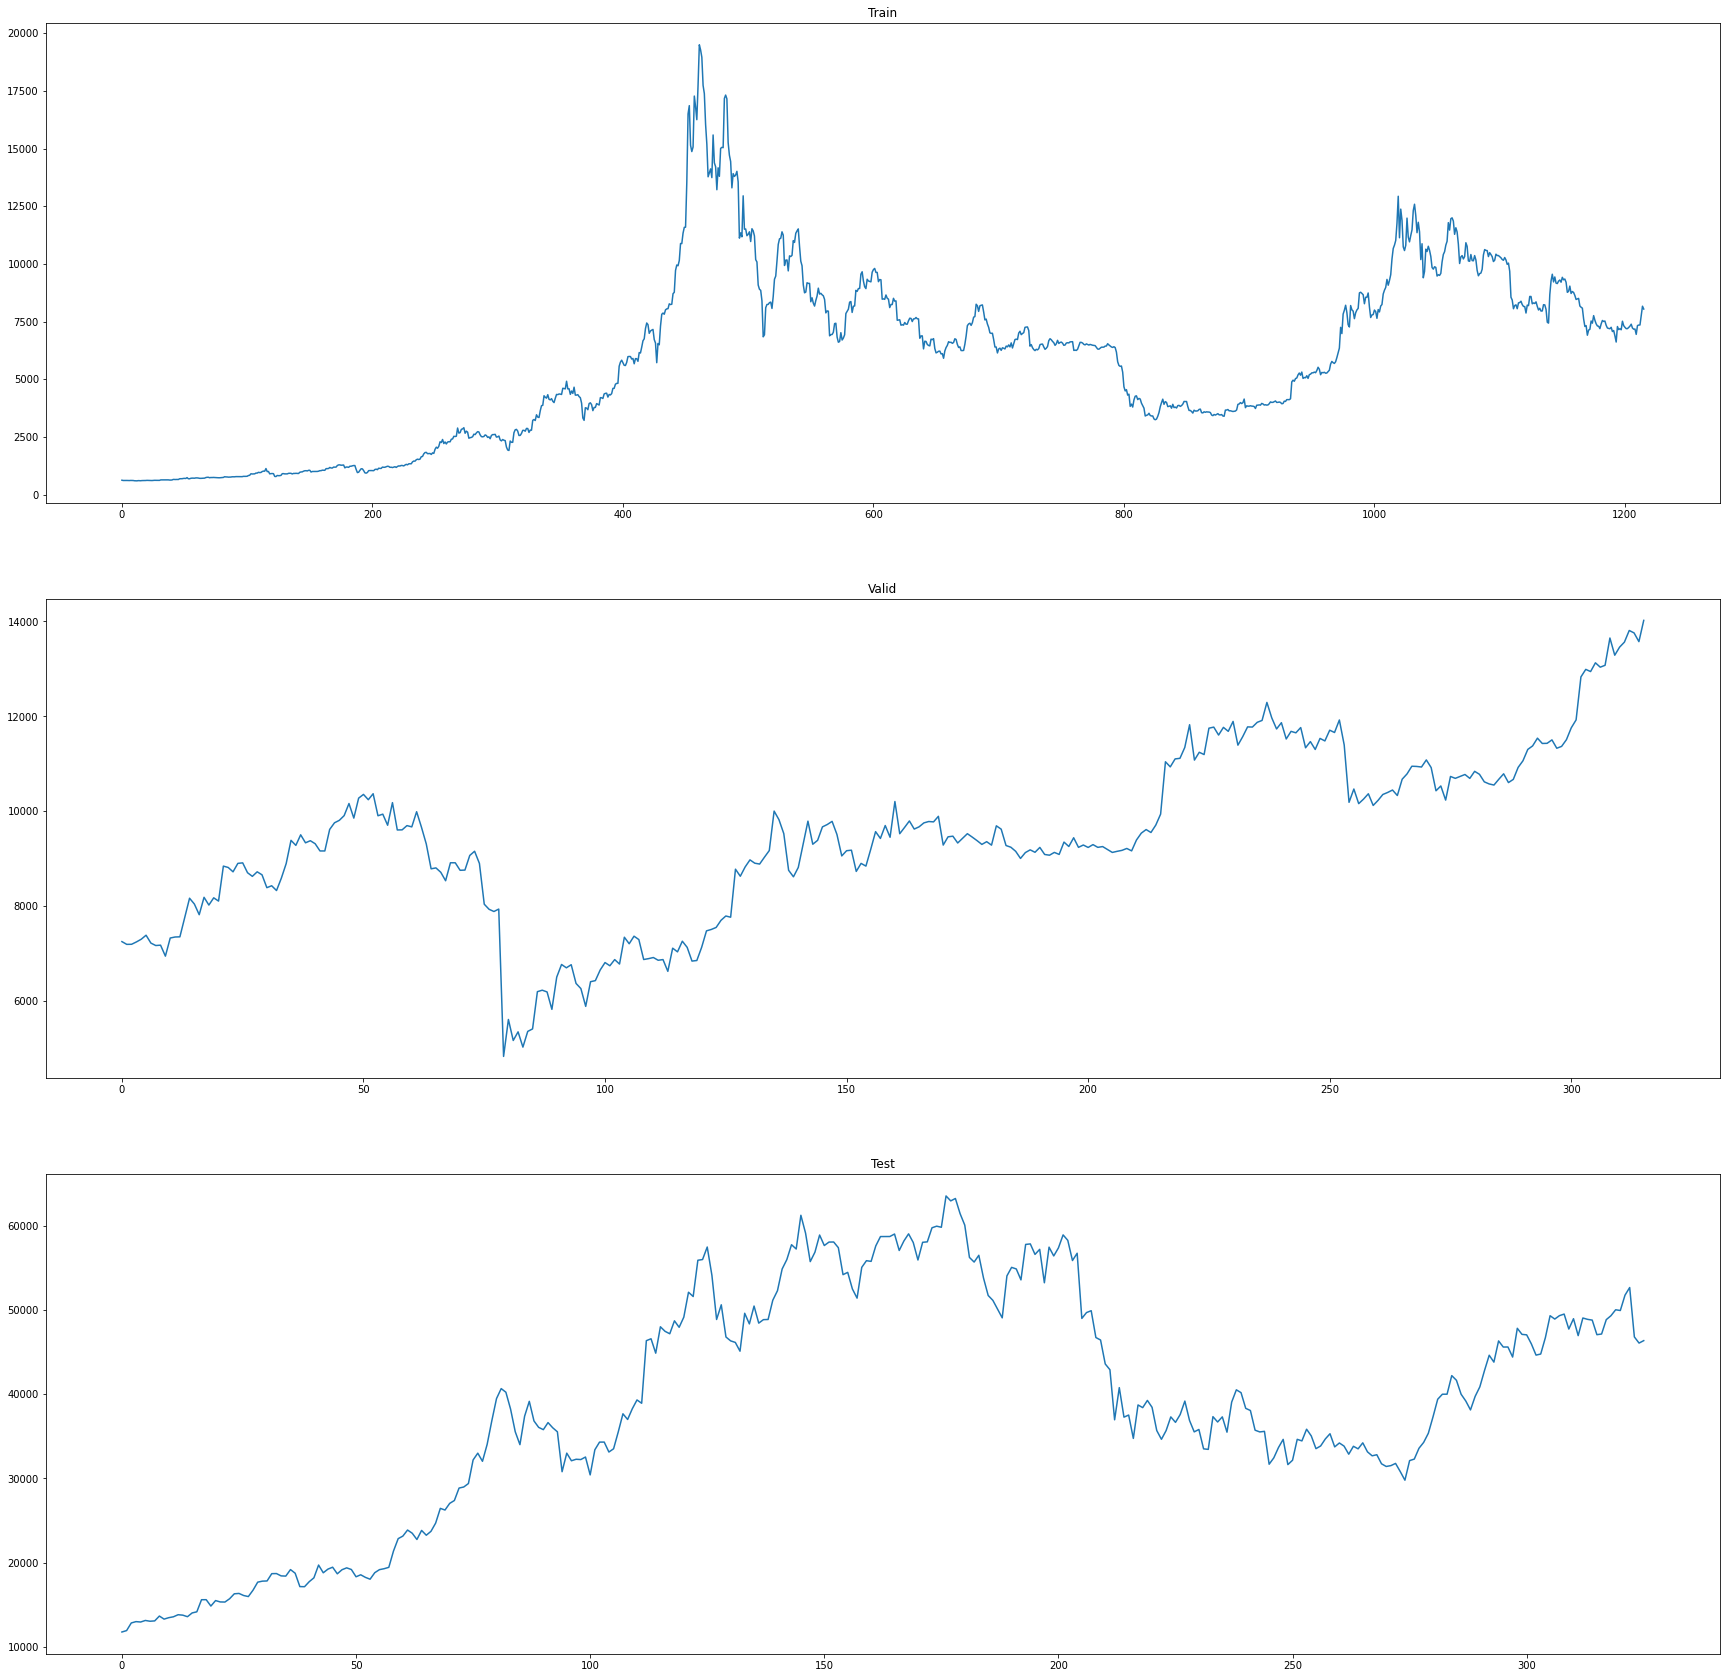

In [34]:
plt.figure(figsize=(30,30))

plt.subplot(311)
plt.title("Train")
plt.plot(train_seq.cpu())

plt.subplot(312)
plt.title("Valid")
plt.plot(valid_seq.cpu())

plt.subplot(313)
plt.title("Test")
plt.plot(test_seq.cpu())

plt.show()

In [35]:
x_train, y_train = [], []
for i in range(bs_len, train_seq.shape[0] - fc_len):
    x_train.append(train_seq[i - bs_len:i])
    y_train.append(train_seq[i: i+fc_len])
    
x_valid, y_valid = [], []
for i in range(bs_len, valid_seq.shape[0] - fc_len):
    x_valid.append(valid_seq[i - bs_len:i])
    y_valid.append(valid_seq[i: i+fc_len])
    
x_test, y_test = [], []
for i in range(bs_len, test_seq.shape[0] - fc_len):
    x_test.append(test_seq[i - bs_len:i])
    y_test.append(test_seq[i: i+fc_len])

print(f"Train: { len(x_train) } Valid: { len(x_valid) } Test: { len(x_test) }")

Train: 1150 Valid: 250 Test: 260


In [36]:
loss_fn = nn.MSELoss()
# for i in trange(epoch):
for i in range(10):
    for j in trange(0, len(x_train) - batch_size):
        xx, yy = torch.stack(x_train[j:j+batch_size]), torch.stack(y_train[j:j+batch_size])
        # xx, yy = x_train[i], y_train[i]
        # xx = xx.permute([1, 0, 2])
        # yy = yy.permute([1, 0, 2])
        pred = forecaster(xx, future=fc_len, y=yy)
        
        optimizer.zero_grad()
        loss = loss_fn(yy.reshape((-1, 2)), pred.reshape((-1, 2)))
        loss.backward()
        optimizer.step()
        
        # if j % 100 == 0:
            # tqdm.write(f"Epoch #{ i } step #{ j } loss = { loss }")
    
    with torch.no_grad():
        j = torch.randint(0, len(x_test) - batch_size, (1,))
        xx_test, yy_test = torch.stack(x_test[j:j+batch_size]), torch.stack(y_test[j:j+batch_size])
        pred = forecaster(xx_test, future=fc_len)
        loss = loss_fn(yy.reshape((-1, 2)), pred.reshape((-1, 2)))
        tqdm.write(f"Test loss = { loss }")

100%|██████████| 1142/1142 [00:17<00:00, 64.71it/s]


Test loss = nan


100%|██████████| 1142/1142 [00:17<00:00, 64.12it/s]


Test loss = nan


100%|██████████| 1142/1142 [00:17<00:00, 64.43it/s]


Test loss = nan


100%|██████████| 1142/1142 [00:17<00:00, 64.28it/s]


Test loss = nan


100%|██████████| 1142/1142 [00:17<00:00, 64.60it/s]


Test loss = nan


 13%|█▎        | 154/1142 [00:02<00:15, 63.99it/s]


KeyboardInterrupt: 

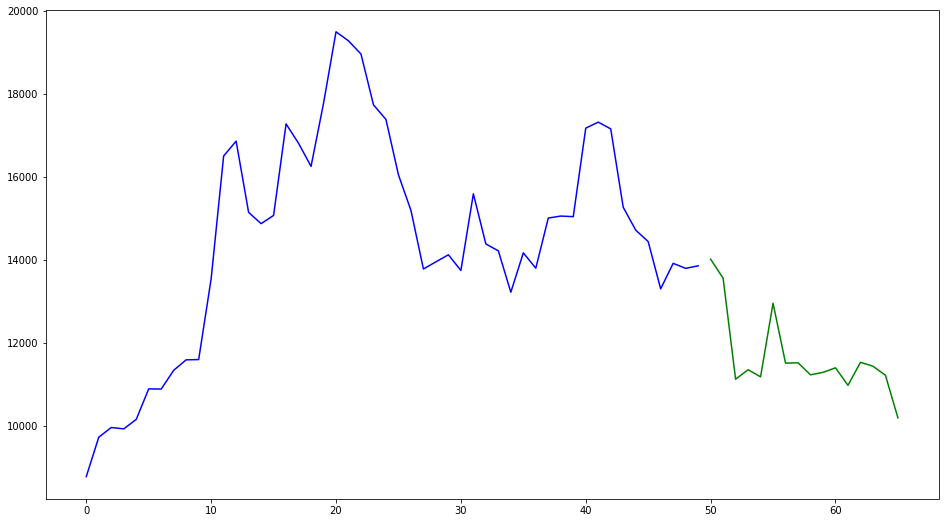

In [ ]:

plt.figure(figsize=(16,9))
plt.plot(np.arange(bs_len), xx[0].detach().cpu(), 'blue')
plt.plot(np.arange(bs_len, bs_len+fc_len), yy[0].detach().cpu(), 'green')
plt.plot(np.arange(bs_len, bs_len+fc_len), pred[0].detach().cpu(), 'red')